<a href="https://colab.research.google.com/github/farahbakhsh3/DeepImageSearch/blob/master/ImageSearch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# pip install faiss-gpu
!nvidia-smi

Wed Dec  4 20:51:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint

import pickle
import numpy as np
import matplotlib.pyplot as plt
from imutils import build_montages
import os

from skimage.io import imread, imshow
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize

from google.colab.patches import cv2_imshow
import cv2

# import matplotlib
# matplotlib.use('Agg')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

print('[INFO] Tensorflow version ' + tf.__version__)

Mounted at /content/drive
[INFO] Tensorflow version 2.17.1


In [18]:
base_dir='/content/drive/My Drive/ImageSearch4/'
cifar10model= base_dir + 'cifar10.h5.keras'
cifar10histplot= base_dir +  'cifar10histplot.png'
cifar10modelplot= base_dir + 'cifar10modelplot.png'
cifar10index= base_dir + 'cifar10index.pickle'
cifar10chptweights= base_dir + 'cifar10weights.h5.keras'

LATENT_DIM= 1024
WIDTH, HEIGTH, DEPTH= (32, 32, 3)

EPOCHS= 50
INIT_LR= 1e-3
BATCH_SIZE= 32
sample= 10
classes= 10

In [6]:
print('[INFO] loading cifar10 dataset...')
((trainX, trainY), (testX, testY))= cifar10.load_data()
trainX= trainX.astype('float32') / 255.0
trainX= trainX.reshape(trainX.shape)
print('Xtrain shape: ', trainX.shape)

testX= testX.astype('float32') / 255.0
testX= testX.reshape(testX.shape)
print('Xtest shape: ', testX.shape)


[INFO] loading cifar10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Xtrain shape:  (50000, 32, 32, 3)
Xtest shape:  (10000, 32, 32, 3)


In [7]:
def build2(width, heigth, depth, latentDim=16):
    inputs= layers.Input(shape=(width, heigth, depth), name='Inputs')
    x= layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu')(inputs)
    x= layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')(inputs)
    x= layers.BatchNormalization()(x)
    x= layers.Dropout(0.25)(x)
    x= layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')(x)
    x= layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x= layers.BatchNormalization()(x)
    x= layers.Dropout(0.25)(x)
    x= layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu')(x)
    x= layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x= layers.BatchNormalization()(x)
    x= layers.Dropout(0.25)(x)

    volumeSize= K.int_shape(x)
    x= layers.Flatten()(x)
    latent= layers.Dense(latentDim, name='Encoded')(x)

    x= layers.Dense(np.prod(volumeSize[1:]))(latent)
    x= layers.Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

    x= layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x= layers.BatchNormalization()(x)
    x= layers.Dropout(0.25)(x)
    x= layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x= layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
    x= layers.BatchNormalization()(x)
    x= layers.Dropout(0.25)(x)

    x= layers.Conv2DTranspose(depth, (3, 3), strides=1, padding='same')(x)
    outputs= layers.Activation('sigmoid', name='Decoded')(x)

    x= layers.Dense(128, activation='relu')(latent)
    x= layers.BatchNormalization()(x)
    x= layers.Dropout(0.25)(x)
    Classifier= layers.Dense(classes, activation='softmax', name='Classifier')(x)


    model= Model(inputs=inputs, outputs=[outputs, Classifier])

    return model

# ===============================

def visualize_predictions(decoded, gt, samples=10):
    outputs=None
    for i in range(0, samples):
        original= (gt[i] * 255).astype('uint8')
        recon= (decoded[i] * 255).astype('uint8')
        output= np.hstack([original, recon])

        if outputs is None:
            outputs= output
        else:
            outputs= np.vstack([outputs, output])

    return outputs


In [12]:
print('[INFO] building autoencoder...')
# tpu= tf.distribute.cluster_resolver.TPUClusterResolver()
# print('[INFO] Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy= tf.distribute.experimental.TPUStrategy(tpu)
# print('[INFO] REPLICAS: ', strategy.num_replicas_in_sync)

# with strategy.scope():
autoencoder= build2(WIDTH, HEIGTH, DEPTH, latentDim=LATENT_DIM)
plot_model(autoencoder, to_file=cifar10modelplot,
           show_shapes=True)
autoencoder.summary()

# opt= Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss=['mse', 'sparse_categorical_crossentropy'], optimizer='adam',
                    metrics=['accuracy', 'accuracy'])


[INFO] building autoencoder...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)       │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 32)     │            896 │ Inputs[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 16, 16, 32)     │            128 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 16, 16, 32)     │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 8, 8, 64)       │            256 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 8, 8, 64)       │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 8, 8, 128)      │         73,856 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 4, 4, 128)      │        147,584 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 4, 4, 128)      │            512 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 4, 4, 128)      │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 2048)           │              0 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoded (Dense)           │ (None, 1024)           │      2,098,176 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2048)           │      2,099,200 │ Encoded[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 4, 4, 128)      │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 8, 8, 128)      │        147,584 │ reshape_1[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9

 Total params: 4,850,381 (18.50 MB)

 Trainable params: 4,849,357 (18.50 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [13]:
checkpointer= ModelCheckpoint(filepath=cifar10chptweights,
                               verbose=0, save_best_only=True)
H= autoencoder.fit(trainX, [trainX, trainY],
                    validation_split=0.1,
					epochs=EPOCHS,
					batch_size=BATCH_SIZE,
					verbose=2,
					callbacks=[checkpointer])

print('[INFO] saving autoencoder...')
autoencoder.save(cifar10model)

Epoch 1/600
1407/1407 - 43s - 30ms/step - Classifier_accuracy: 0.4168 - Classifier_loss: 1.6332 - Decoded_accuracy: 0.5607 - Decoded_loss: 0.0287 - loss: 1.6615 - val_Classifier_accuracy: 0.4190 - val_Classifier_loss: 1.6504 - val_Decoded_accuracy: 0.6034 - val_Decoded_loss: 0.0231 - val_loss: 1.6700
Epoch 2/600
1407/1407 - 14s - 10ms/step - Classifier_accuracy: 0.5527 - Classifier_loss: 1.2566 - Decoded_accuracy: 0.6273 - Decoded_loss: 0.0249 - loss: 1.2816 - val_Classifier_accuracy: 0.5756 - val_Classifier_loss: 1.2065 - val_Decoded_accuracy: 0.6503 - val_Decoded_loss: 0.0291 - val_loss: 1.2361
Epoch 3/600
1407/1407 - 10s - 7ms/step - Classifier_accuracy: 0.6261 - Classifier_loss: 1.0576 - Decoded_accuracy: 0.6445 - Decoded_loss: 0.0239 - loss: 1.0816 - val_Classifier_accuracy: 0.6808 - val_Classifier_loss: 0.9011 - val_Decoded_accuracy: 0.6578 - val_Decoded_loss: 0.0202 - val_loss: 0.9190
Epoch 4/600
1407/1407 - 21s - 15ms/step - Classifier_accuracy: 0.6783 - Classifier_loss: 0.9154

[INFO] saving autoencoder...


[INFO] making predictions...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


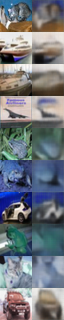

[INFO] makeing autoencoder plot ...


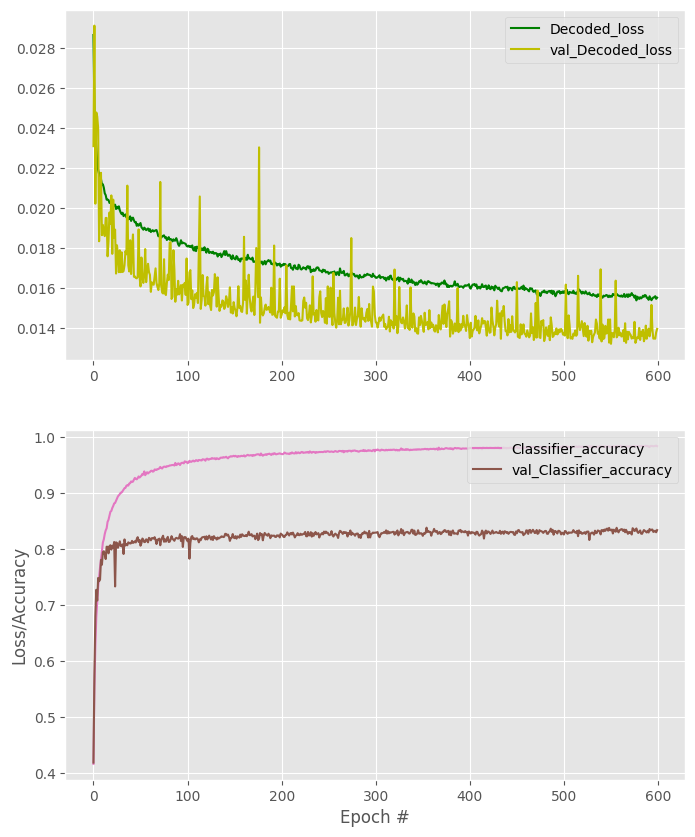

In [16]:
print('[INFO] making predictions...')
decoded= autoencoder.predict(testX)[0]
vis= visualize_predictions(decoded, testX)
cv2_imshow(vis)

print('[INFO] makeing autoencoder plot ...')
N= np.arange(0, EPOCHS)
plt.style.use('ggplot')
fig= plt.figure(figsize=(8,10))
axs= fig.subplots(nrows=2, ncols=1)
axs[0].plot(N, H.history['Decoded_loss'], label='Decoded_loss', color='g')
axs[0].plot(N, H.history['val_Decoded_loss'], label='val_Decoded_loss', color='y')
axs[1].plot(N, H.history['Classifier_accuracy'], label='Classifier_accuracy', color='tab:pink')
axs[1].plot(N, H.history['val_Classifier_accuracy'], label='val_Classifier_accuracy', color='tab:brown')
axs[1].set_xlabel('Epoch #')
axs[1].set_ylabel('Loss/Accuracy')
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')


In [20]:
# print('[INFO] loading cifar10 training split...')
# ((trainX, _), (testX, _))= cifar10.load_data()

# trainX= trainX.astype('float32') / 255.0

print('[INFO] loading autoencoder model...')
autoencoder= load_model(cifar10model)

encoder= Model(inputs=autoencoder.input,
                outputs=autoencoder.get_layer('Encoded').output)

print('[INFO] encoding images...')
features= encoder.predict(trainX)

indexes= list(range(0, trainX.shape[0]))
data= {'indexes': indexes, 'features': features}

print('[INFO] saving index...')
f= open(cifar10index, 'wb')
f.write(pickle.dumps(data))
f.close()

[INFO] loading autoencoder model...


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 40 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[INFO] encoding images...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
[INFO] saving index...


[INFO] loading autoencoder and index...
[INFO] encoding testing images...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


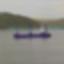

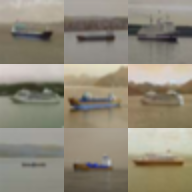

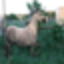

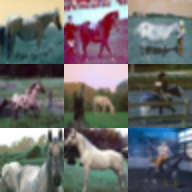

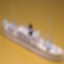

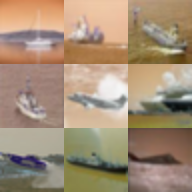

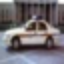

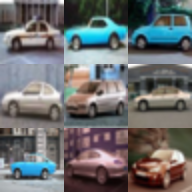

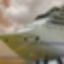

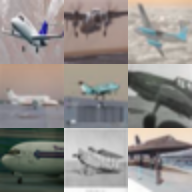

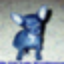

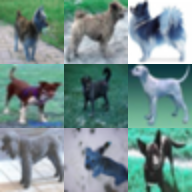

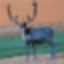

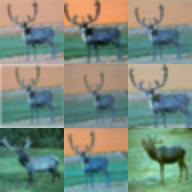

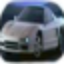

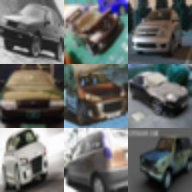

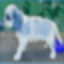

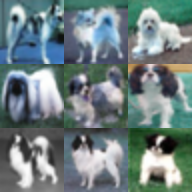

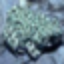

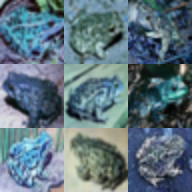

In [21]:
def euclidean(a, b):
    diff= np.linalg.norm(a - b)
    return diff

def perform_search(queryFeatures, index, maxResults=64):
	results= []

	for i in range(0, len(index['features'])):
		d= euclidean(queryFeatures, index['features'][i])
		results.append((d, i))

	results= sorted(results)[:maxResults]

	return results

# print('[INFO] loading cifar10 dataset...')
# ((trainX, _), (testX, _))= cifar10.load_data()

# trainX= trainX.astype('float32') / 255.0
# testX= testX.astype('float32') / 255.0

print('[INFO] loading autoencoder and index...')
autoencoder= load_model(cifar10model)
index= pickle.loads(open(cifar10index, 'rb').read())

encoder= Model(inputs=autoencoder.input,
                outputs=autoencoder.get_layer('Encoded').output)

print('[INFO] encoding testing images...')
features= encoder.predict(testX)

queryIdxs= list(range(0, testX.shape[0]))
queryIdxs= np.random.choice(queryIdxs, size=sample,
                             replace=False)

for i in queryIdxs:
	queryFeatures= features[i]
	results= perform_search(queryFeatures, index, 64)
	images= []

	for (d, j) in results:
		image= (trainX[j] * 255).astype('uint8')
		images.append(image)

	query= (testX[i] * 255).astype('uint8')
	cv2_imshow(cv2.resize(query, (64,64)))

	montage= build_montages(images, (64, 64), (3, 3))[0]
	cv2_imshow(montage)
